**This EfficientNetV2 is implemented by Zhao Zixun (57853911)**

**Introduction to EfficientNetV2**

EfficientNetV2 is an advanced family of convolutional neural networks (CNNs) designed for image classification and other computer vision tasks. It was introduced as a successor to the original EfficientNet by combining improved scalability, computational efficiency, and faster training times. The design emphasizes a trade-off between accuracy and computational cost.

Key Features:

Faster Training: EfficientNetV2 employs progressive learning, where the resolution of input images gradually increases during training, making it more efficient.
Enhanced Architecture: It refines the original EfficientNet architecture with advanced features like fused MBConv layers that combine depthwise separable convolutions and traditional convolutions for improved speed and performance.
Scalability: EfficientNetV2 utilizes a compound scaling approach, optimizing depth, width, and resolution to achieve a better balance between accuracy and computational cost.
Lightweight Models: It includes smaller variants (e.g., EfficientNetV2-S, EfficientNetV2-M) designed for resource-constrained environments, while larger models provide state-of-the-art results.

In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq


In [ ]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time
import math
from collections import OrderedDict
from functools import partial
from typing import Callable, Optional
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import os, json, math
from PIL import Image, ImageDraw

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 12)
PyTorch version: 2.5.1+cu121
Device: cuda


In [ ]:
# 定义 drop_path 函数
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x / keep_prob * random_tensor
    return output

# 定义 ConvBNAct 类用于卷积、BN 和激活函数的组合
class ConvBNAct(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size, stride, act_layer=nn.SiLU):
        super().__init__()
        self.conv = nn.Conv2d(in_chs, out_chs, kernel_size, stride, kernel_size // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_chs)
        self.act = act_layer()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# 定义 SqueezeExcite 模块
class SqueezeExcite(nn.Module):
    def __init__(self, in_chs, se_ratio=0.25):
        super(SqueezeExcite, self).__init__()
        reduced_chs = max(1, int(in_chs * se_ratio))
        self.fc1 = nn.Conv2d(in_chs, reduced_chs, 1)
        self.fc2 = nn.Conv2d(reduced_chs, in_chs, 1)

    def forward(self, x):
        scale = F.adaptive_avg_pool2d(x, 1)
        scale = torch.sigmoid(self.fc2(F.silu(self.fc1(scale))))
        return x * scale

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


train_path = '/content/drive/MyDrive/Colab Notebooks/trainset'
test_path = '/content/drive/MyDrive/Colab Notebooks/testset'


In [ ]:

from torchvision import transforms

# 数据增强部分
train_transform = transforms.Compose([
    # 数据增强部分增加了旋转和随机仿射变换
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(degrees=45),  # 增加旋转
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    #transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=20),  # 增加仿射变换
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 测试集的数据增强保持不变
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
train_set = datasets.ImageFolder(root=train_path, transform=train_transform)
test_set = datasets.ImageFolder(root=test_path, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


# Define the classes if they are known
classes = [
    '云芝', '冬菇', '冬虫夏草','出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌',
    '尾花笼头菌', '干巴菌','恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳','毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞',
    '灵芝','牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌',
    '紫蜡蘑','綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇' ,'细褐鳞蘑菇', '羊肚菌', '美味牛肝菌','蓝绿乳菇', '裂褶菌',
    '赭红拟口蘑', '金黃鵝膏菌','鳞柄白鹅膏','鹿蕊', '黄裙竹荪', '黑松露'
]


# Check dataset loading
print("Number of training samples:", len(train_set))
print("Number of test samples:", len(test_set))
print("Classes:", classes)
print("Class to index mapping:", train_set.class_to_idx)
print(len(classes))



Number of training samples: 7548
Number of test samples: 1367
Classes: ['云芝', '冬菇', '冬虫夏草', '出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌', '尾花笼头菌', '干巴菌', '恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳', '毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞', '灵芝', '牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌', '紫蜡蘑', '綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇', '细褐鳞蘑菇', '羊肚菌', '美味牛肝菌', '蓝绿乳菇', '裂褶菌', '赭红拟口蘑', '金黃鵝膏菌', '鳞柄白鹅膏', '鹿蕊', '黄裙竹荪', '黑松露']
Class to index mapping: {'云芝': 0, '冬菇': 1, '冬虫夏草': 2, '出血齿菌': 3, '变绿红菇': 4, '大青褶伞': 5, '大鹿花菌': 6, '宽鳞多孔菌': 7, '尾花笼头菌': 8, '干巴菌': 9, '恶魔雪茄蘑菇': 10, '杏鮑菇': 11, '欧洲黑木耳': 12, '毒丝盖伞': 13, '毒蕈': 14, '毒蝇伞': 15, '毛头鬼伞': 16, '灵芝': 17, '牛舌菌': 18, '狭头小菇': 19, '猴头菇': 20, '硫黄菌': 21, '竹荪': 22, '粉红枝瑚菌': 23, '粪生黑蛋巢菌': 24, '紫蜡蘑': 25, '綠蓋粉孢牛肝菌': 26, '红笼头菌': 27, '红紫柄小菇': 28, '细褐鳞蘑菇': 29, '羊肚菌': 30, '美味牛肝菌': 31, '蓝绿乳菇': 32, '裂褶菌': 33, '赭红拟口蘑': 34, '金黃鵝膏菌': 35, '鳞柄白鹅膏': 36, '鹿蕊': 37, '黄裙竹荪': 38, '黑松露': 39}
40


Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Available fonts: ['/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', '/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc', '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/opentype/noto/No

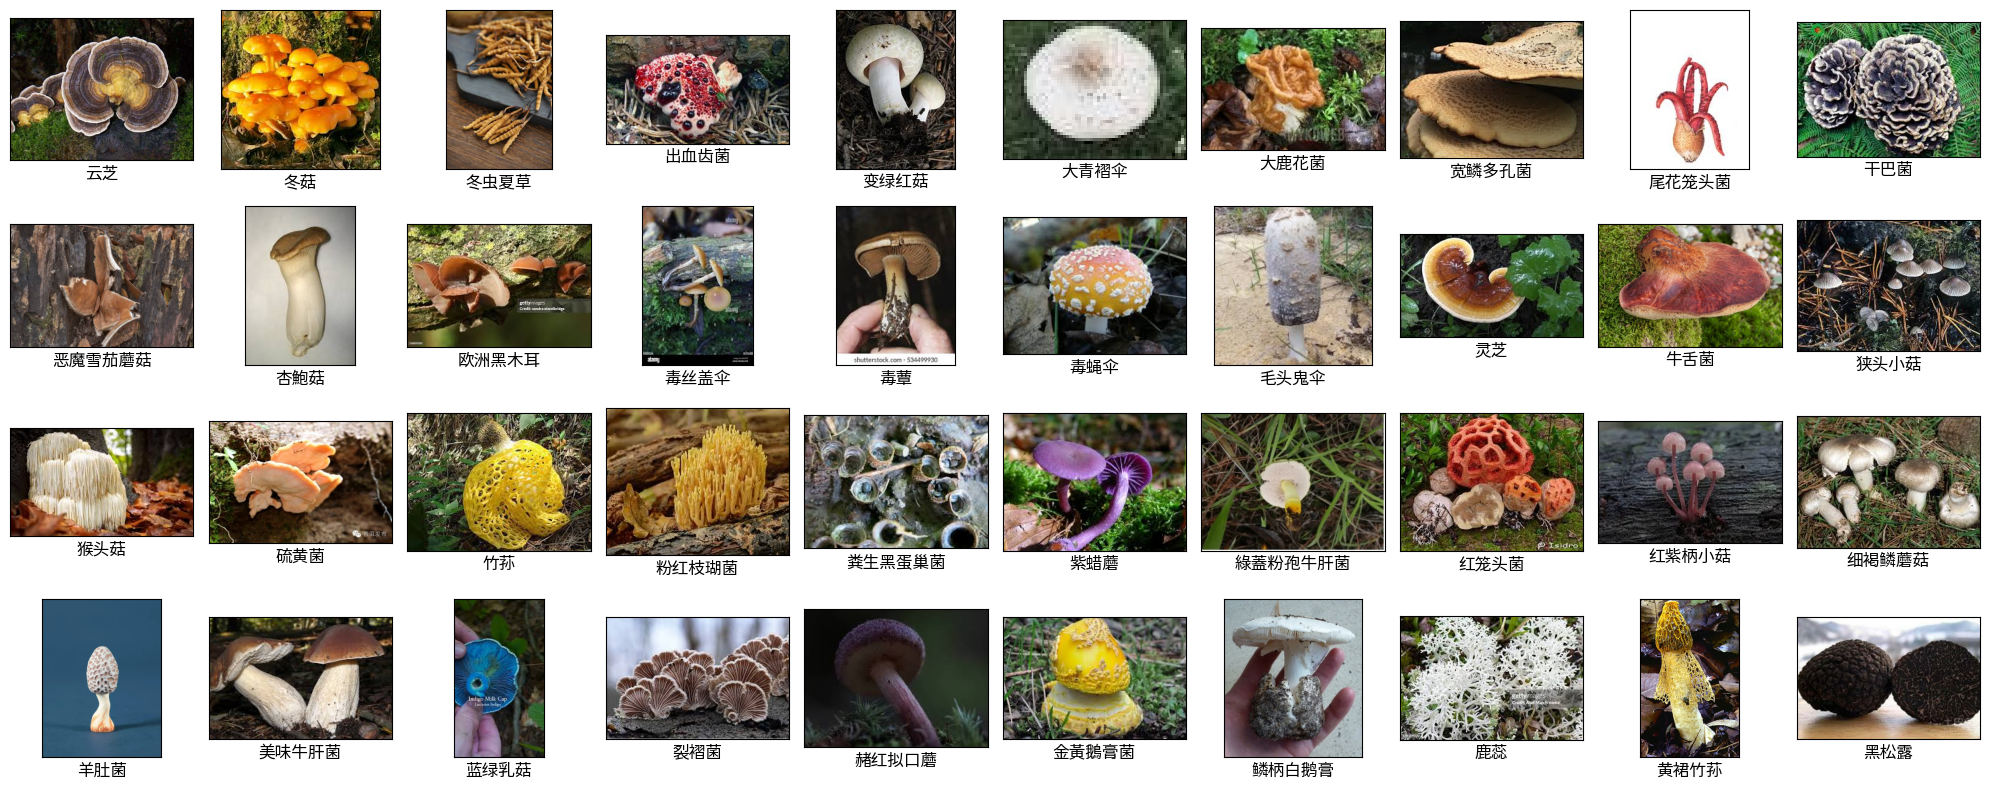

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets, transforms

# 下载并安装中文字体
!apt-get -qq install -y fonts-noto-cjk

import matplotlib.font_manager as fm

# 查找可用的 Noto 字体
font_dirs = fm.findSystemFonts(fontpaths=None)
print("Available fonts:", font_dirs)

# 设置使用的中文字体
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # 正确的字体路径
font_prop = fm.FontProperties(fname=font_path)

# 获取类别数
num_classes = len(classes)
classes = train_set.classes
print(len(train_set.classes))

# 确保 classes 和 train_set.class_to_idx 对应
class_idx_to_chinese = {v: classes[v] for v in range(len(classes))}

# 每个类别选择一张示例图像
sample_images = []
for label in range(len(classes)):
    # 找到第一个属于当前类别的图像
    for path, target in train_set.imgs:
        if target == label:
            img = Image.open(path).convert("RGB")  # 转换为RGB
            sample_images.append((img, class_idx_to_chinese[label]))  # 用中文名作为标签
            break

# 设置显示网格
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        if i < len(sample_images):
            img, label = sample_images[i]
            axis.set_xlabel(label, fontsize=12, fontproperties=font_prop)  # 中文标签
            axis.imshow(img)
        else:
            axis.axis('off')  # 如果样本不足，关闭多余的子图框
        i += 1

plt.tight_layout()
plt.show()

In [ ]:

import torch
import torch.nn as nn
from collections import OrderedDict

# 定义 ConvBNAct 类用于卷积、BatchNorm和激活函数的组合
class ConvBNAct(nn.Sequential):
    def __init__(self, in_chs, out_chs, kernel_size=3, stride=1, act_layer=nn.SiLU):
        super(ConvBNAct, self).__init__(
            nn.Conv2d(in_chs, out_chs, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2, bias=False),
            nn.BatchNorm2d(out_chs),
            act_layer()
        )

# 定义 MBConv 和 FusedMBConv 类
class MBConv(nn.Module):
    def __init__(self, in_chs, out_chs, stride, expand_ratio, drop_path=0.):
        super(MBConv, self).__init__()
        self.has_residual = (in_chs == out_chs) and (stride == 1)
        hidden_dim = int(round(in_chs * expand_ratio))
        layers = OrderedDict()

        if expand_ratio != 1:
            layers["expansion_conv"] = ConvBNAct(in_chs, hidden_dim, kernel_size=1, stride=1)
        layers["depthwise_conv"] = ConvBNAct(hidden_dim, hidden_dim, kernel_size=3, stride=stride)
        layers["se"] = SqueezeExcite(hidden_dim)
        layers["project_conv"] = nn.Sequential(nn.Conv2d(hidden_dim, out_chs, 1, bias=False), nn.BatchNorm2d(out_chs))
        self.block = nn.Sequential(layers)
        self.drop_path = drop_path

    def forward(self, x):
        residual = x
        x = self.block(x)
        if self.has_residual:
            x += residual
        return x

class FusedMBConv(nn.Module):
    def __init__(self, in_chs, out_chs, stride, expand_ratio, drop_path=0.):
        super(FusedMBConv, self).__init__()
        self.has_residual = (in_chs == out_chs) and (stride == 1)
        hidden_dim = int(round(in_chs * expand_ratio))
        if expand_ratio != 1:
            self.expansion_conv = ConvBNAct(in_chs, hidden_dim, 3, stride)
        else:
            self.expansion_conv = nn.Identity()
        self.project_conv = ConvBNAct(hidden_dim, out_chs, 1, stride=1)
        self.drop_path = drop_path

    def forward(self, x):
        residual = x
        x = self.expansion_conv(x)
        x = self.project_conv(x)
        if self.has_residual:
            x += residual
        return x

class SqueezeExcite(nn.Module):
    def __init__(self, in_chs, se_ratio=0.25):
        super(SqueezeExcite, self).__init__()
        reduced_chs = max(1, int(in_chs * se_ratio))
        self.fc1 = nn.Conv2d(in_chs, reduced_chs, 1)
        self.fc2 = nn.Conv2d(reduced_chs, in_chs, 1)

    def forward(self, x):
        scale = torch.sigmoid(self.fc2(F.silu(self.fc1(x.mean((2, 3), keepdim=True)))))
        return x * scale

class EfficientNetV2(nn.Module):
    def __init__(self, model_cnf, num_classes=40, dropout_rate=0.5, drop_connect_rate=0.2):
        super(EfficientNetV2, self).__init__()
        self.stem = ConvBNAct(3, model_cnf[0][0], kernel_size=3, stride=2)
        self.blocks = nn.Sequential(*[self._make_block(*cfg) for cfg in model_cnf])
        self.head = nn.Sequential(OrderedDict([
            ("conv", nn.Conv2d(model_cnf[-1][1], 1280, 1, bias=False)),
            ("bn", nn.BatchNorm2d(1280)),
            ("act", nn.SiLU())
        ]))
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(1280, num_classes)

    def _make_block(self, in_chs, out_chs, stride, expand_ratio, block_type, se_ratio, drop_path, drop_rate):
        layers = []
        if block_type == "MBConv":
            layers.append(MBConv(in_chs, out_chs, stride, expand_ratio, drop_path))
        elif block_type == "FusedMBConv":
            layers.append(FusedMBConv(in_chs, out_chs, stride, expand_ratio, drop_path))
        else:
            raise ValueError("Unsupported block type")
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.avgpool(x).view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


**Define CNN Model**

In [ ]:

# 增加了模型的复杂度，增加了更多的 MBConv 和 FusedMBConv 块，并提高了 expand_ratio
model_config = [
    [24, 48, 2, 6, "MBConv", 0.25, 0.0, 0.0],  # 使用更高的 expand_ratio
    [48, 80, 2, 6, "FusedMBConv", 0.25, 0.0, 0.0],
    [80, 160, 2, 6, "MBConv", 0.25, 0.1, 0.0],  # 增加了一个 MBConv 块
    [160, 256, 2, 6, "FusedMBConv", 0.25, 0.1, 0.0],  # 增加了一个新的 FusedMBConv 块
]


# 初始化模型
# model = EfficientNetV2(model_cnf=model_config)
# model.to(device)  # 将模型移动到指定设备

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2(model_cnf=model_config, num_classes=40, dropout_rate=0.4, drop_connect_rate=0.3)  # 调整 dropout_rate 和 drop_connect_rate
model.to(device)

EfficientNetV2(
  (stem): ConvBNAct(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): MBConv(
        (block): Sequential(
          (expansion_conv): ConvBNAct(
            (0): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU()
          )
          (depthwise_conv): ConvBNAct(
            (0): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU()
          )
          (se): SqueezeExcite(
            (fc1): Conv2d(144, 36, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(36, 144, kernel_size=(1, 

Train the model

In [ ]:
# 打印模型结构
print("Model Structure:")
for name, module in model.named_children():
    print(f"{name}:")
    for sub_name, sub_module in module.named_children():
        print(f"  {sub_name}: {sub_module}")

Model Structure:
stem:
  0: Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  1: BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  2: SiLU()
blocks:
  0: Sequential(
  (0): MBConv(
    (block): Sequential(
      (expansion_conv): ConvBNAct(
        (0): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (depthwise_conv): ConvBNAct(
        (0): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (se): SqueezeExcite(
        (fc1): Conv2d(144, 36, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(36, 144, kernel_size=(1, 1), stride=(1, 1))
      )
      (project_conv): Sequential(
        (0): Conv2d(144, 48, kernel_size=(1, 1), 

In [ ]:

# Create a Models folder to store the checkpoints
!mkdir Models

In [ ]:
# 损失函数
criterion = nn.CrossEntropyLoss()

# 调整优化器和学习率调度器
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=90)  # 使用 CosineAnnealingLR

In [ ]:
# 训练设置
EPOCHS = 90
loss_hist, acc_hist = [], []
loss_hist_test, acc_hist_test = [], []

print("Training started.\n")
for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")

    running_loss = 0.0
    correct = 0
    model.train()

    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    scheduler.step()

    avg_loss = running_loss / len(train_set)
    avg_acc = correct / len(train_set)
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    model.eval()
    with torch.no_grad():
        loss_test = 0.0
        correct_test = 0

        for data in test_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            loss_test += loss.item()

        avg_loss_test = loss_test / len(test_set)
        avg_acc_test = correct_test / len(test_set)
        loss_hist_test.append(avg_loss_test)
        acc_hist_test.append(avg_acc_test)

    with open("Models/efficientnetv2_model_{}.pth".format(epoch), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    print(f"Train Loss: {avg_loss:.3f}", end=" ")
    print(f"Test Loss: {avg_loss_test:.3f}", end=" ")
    print(f"Train Accuracy: {avg_acc * 100:.2f}%", end=" ")
    print(f"Test Accuracy: {avg_acc_test * 100:.2f}%", end=" ")
    print(f"Time: {time.time() - time_ckpt:.2f}s", end="\n")


Training started.

EPOCH: 1 Train Loss: 0.103 Test Loss: 0.095 Train Accuracy: 10.73% Test Accuracy: 18.73% Time: 7105.22s
EPOCH: 2 Train Loss: 0.095 Test Loss: 0.086 Train Accuracy: 15.78% Test Accuracy: 25.09% Time: 173.37s
EPOCH: 3 Train Loss: 0.091 Test Loss: 0.081 Train Accuracy: 19.30% Test Accuracy: 27.36% Time: 172.14s
EPOCH: 4 Train Loss: 0.088 Test Loss: 0.081 Train Accuracy: 22.38% Test Accuracy: 24.58% Time: 172.98s
EPOCH: 5 Train Loss: 0.085 Test Loss: 0.074 Train Accuracy: 24.64% Test Accuracy: 31.97% Time: 174.47s
EPOCH: 6 Train Loss: 0.080 Test Loss: 0.069 Train Accuracy: 28.42% Test Accuracy: 36.21% Time: 174.20s
EPOCH: 7 Train Loss: 0.077 Test Loss: 0.071 Train Accuracy: 30.46% Test Accuracy: 34.24% Time: 171.83s
EPOCH: 8 Train Loss: 0.075 Test Loss: 0.067 Train Accuracy: 31.97% Test Accuracy: 38.41% Time: 172.30s
EPOCH: 9 Train Loss: 0.073 Test Loss: 0.061 Train Accuracy: 34.35% Test Accuracy: 45.94% Time: 174.16s
EPOCH: 10 Train Loss: 0.071 Test Loss: 0.061 Train Ac

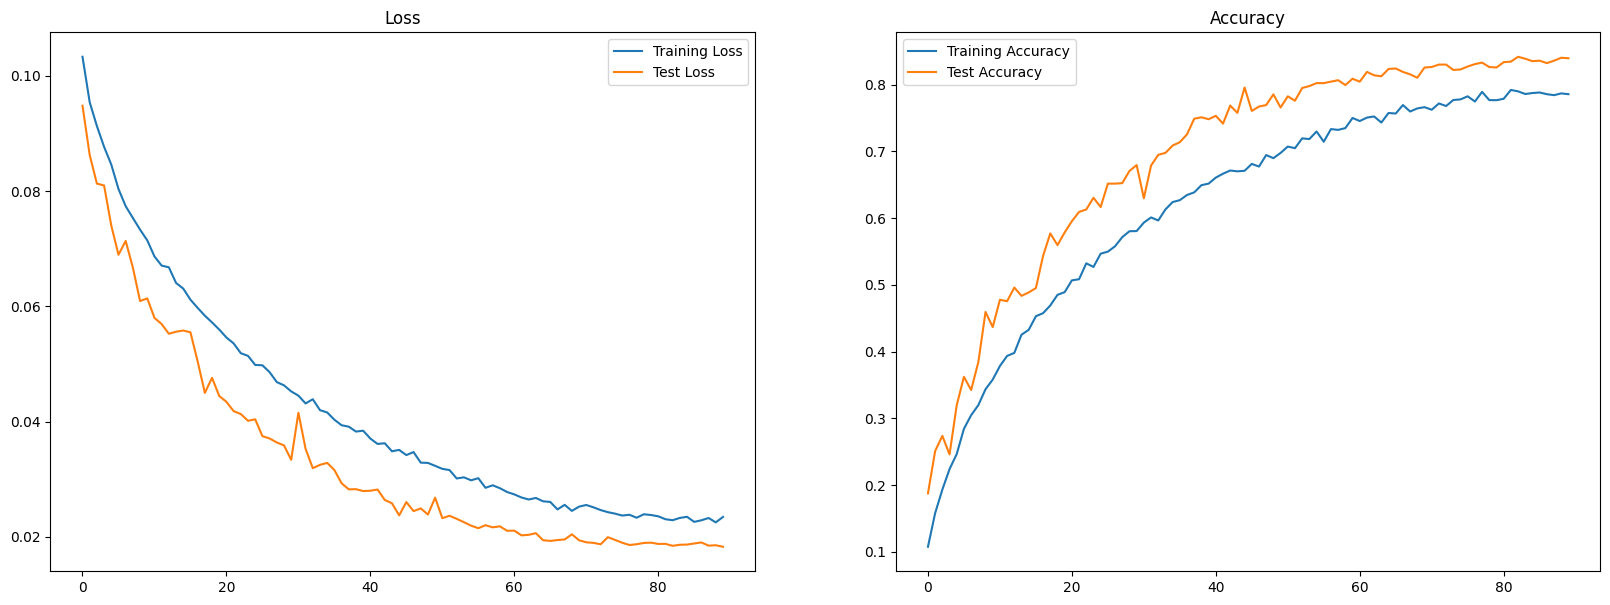

In [ ]:
plots=[(loss_hist,loss_hist_test),(acc_hist,acc_hist_test)]
plt_labels=[("Training Loss","Test Loss"),("Training Accuracy","Test Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

In [ ]:
# Selecting the best model
best_acc = max(acc_hist_test)
best_epoch = acc_hist_test.index(best_acc)+1

print("Best accuracy on test set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models/efficientNetv2_model_{best_epoch}.pth","rb") as f:
    model=pickle.load(f)


In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
avg_test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

    avg_test_loss = test_loss / len(test_set)

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)


In [ ]:
print(F"Test Loss: {avg_test_loss}")
print(F"Test Accuracy on the {len(test_set)} test images: {(100 * correct / len(test_set))}%")

In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

In [ ]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=report)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets, transforms

# 下载并安装中文字体
!apt-get -qq install -y fonts-noto-cjk

import matplotlib.font_manager as fm

# 查找可用的 Noto 字体
font_dirs = fm.findSystemFonts(fontpaths=None)
print("Available fonts:", font_dirs)

# 设置使用的中文字体
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # 正确的字体路径
font_prop = fm.FontProperties(fname=font_path)
# obtain one batch of test images
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
  # Normalize the image tensor to [0, 1] range
  image = images[idx].permute(1, 2, 0)
  image = (image - image.min()) / (image.max() - image.min())
  ax.imshow(image)  # Display the image
  ax.axis('off')  # Hide the axes
  ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))  # Add title to the image
plt.show()

In [ ]:
# Define the loader for all test data
test_set = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)



# obtain one batch of test images
dataiter = iter(test_set)
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for idx in range(50):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax = fig.add_subplot(5, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(image, interpolation='nearest')

    if preds[idx]==labels[idx]:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='green')
    else:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='red')

plt.show()


In [ ]:

# Visualize wrongly classified image for each class
pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss=criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [test_set_all.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results_all = [pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=10)
    axis.imshow(incorrect_images[i], cmap='gray')
    i += 1